# Предсказание температуры сплава

Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Нам нужно построить модель, которая предскажет температуру стали.

## Примерный план решения задачи

1. Изучение данных
2. Исследовательский анализ данных
3. Подготовка данных. Объединение таблиц
4. Подготовка признаков
5. Проверка признаков на мультиколлинеарность
6. Разбиение датасета на тренировочный и тестовый наборы
7. Создание модели. Подбор гиперпараметров с помощью кросс-валидации
8. Тестирование модели
9. Анализ важности признаков у модели
10. Проверка модели на вменяемость

Проект выполнен в **Jupyter Notebook**, версия сервера блокнотов: 6.4.6.  
Версия **Python** 3.10.1.  
В проекте использованы библиотеки:  
* **Pandas**
* **NumPy** 
* **Seaborn** 
* **MatPlotLib** 
* **statsmodel** 
* **scikit-learn**
* **модуль IPython**
* **Light GBM**

## 1. Изучение данных

In [1]:
# Импортируем библиотеки.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import time

In [2]:
# Прочитаем датасеты.
data_arc = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_arc.csv'
)
data_bulk = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_bulk.csv'
)
data_bulk_time = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_bulk_time.csv'
)
data_gas = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_gas.csv'
)
data_temp = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_temp.csv'
)
data_wire = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_wire.csv'
)
data_wire_time = pd.read_csv(
    'D:/Обучение/Яндекс.Практикум/Проекты/Проект 14. Предсказание температуры стали/final_steel/final_steel/data_wire_time.csv'
)

In [3]:
# Напишем небольшую функцию для просмотра
# информации.
def info(dataset):
    dataset.info()
    display(dataset)
# Список наших таблиц.
datasets = [data_arc, data_bulk,
           data_bulk_time, data_gas,
           data_temp, data_wire, data_wire_time]
# Воспользуемся функцией.
for i in datasets:
    info(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проведём первичный анализ данных.  

**Таблица data_arc**  
В таблице хранятся данные о графитовых электродах, применяемых для подогрева расплавленной стали методом дугового нагрева.  
В столбце *key* указывается номер партии. В следуюших двух столбцах — дата и время начала и конца дугового нагрева. Затем активная и реактивная мощности используемого при нагревании тока.  
  
*Предложения по обработке датасета*  
* Проверить датасет на наличие полных дубликатов
* Посмотреть уникальные значения в столбце *key*. Надо понять сколько всего было партий
* Проверить столбцы *Начало нагрева дугой* и *Конец нагрева дугой* на дубликаты. Если они будут, возможно удалим такие строки
* Кажется, дата и время начала и конца нагрева дугой нам не нужны. Избавимся от них
* Проверить столбцы с активной и реактивной мощностью на наличие выбросов. Построить диаграммы размаха
* Сгруппировать данные в таблице по номеру партии и просуммировать значения мощностей. Физического смысла в суммировании временных удельных величин нет в данном случае, но, на мой взгляд, суммирование сделает признаки более "точными", более "ёмкими" для нашей будущей модели. Передаст ей больше неискаженной информации, чем среднее значение, которое в физическом смысле, конечно, подходит больше

**Таблица data_bulk**  
В таблице хранятся данные об объеме сыпучих материалов, добавленных в сталь при легировании. Всего у нас 15 сыпучих материалов. Названия материалов нам не известны. Мы видим только их номера. Например, `Bulk 1`, `Bulk 2` и т.д.

*Предложения по обработке датасета*  
* Заменить `NaN` на нули. В данном случае `NaN` означает, что в этой партии этот сыпучий материал не применялся.
* Посмотреть уникальные значения в столбце *key*. Надо понять сколько всего было партий.

**Таблица data_bulk_time**  
В таблице хранятся данные о времени подачи сыпучих материалов, добавленных в сталь при легировании. Всего у нас 15 сыпучих материалов. Названия материалов нам не известны. Мы видим только их номера. Например, `Bulk 1`, `Bulk 2` и т.д.

*Предложения по обработке датасета*  
* Заменим `NaN`-значения на 0
* Поменяем тип данных на DateTime

**Таблица data_gas**  
В таблице хранятся данные о каком-то параметре инертного газа, которым продувают сплав.

*Предложения по обработке датасета*  
* `NaN`-значений нет
* Проверим на полные дубликаты
* Проверим столбец на наличие выбросов. Построим диаграмму размаха

**Таблица data_temp**  
В таблице хранятся данные о температуре сплава, времени замера.

*Предложения по обработке датасета*  
* Температура стали последней итерации каждой партии — это наш целевой признак
* Проверим на полные дубликаты
* Проверим столбец на наличие выбросов. Построим диаграмму размаха
* Поменяем тип данных столбца *Время замера* на DateTime
* Поищем закономерности, по которым в наборе данных есть `NaN`-значения. Это поможет нам выработать стратегию их обработки

**Таблица data_wire**  
В таблице хранятся данные об объеме проволоки, добавленной в сталь при легировании. Всего у нас 9 видов проволоки. Названия проволоки нам не известны. Мы видим только их номера. Например, `Wire 1`, `Wire 2` и т.д.

*Предложения по обработке датасета*  
* Заменить `NaN` на нули. В данном случае `NaN` означает, что в этой партии эта проволока не применялась.

**Таблица data_wire_time**  
В таблице хранятся данные о времени подачи проволоки, добавленной в сталь при легировании. Всего у нас 9 видов проволоки. Названия проволоки нам не известны. Мы видим только их номера. Например, `Wire 1`, `Wire 2` и т.д.

*Предложения по обработке датасета*  
* Заменим `NaN`-значения на нули
* Поменяем тип данных на DateTime

После проведения исследовательского анализа мы сможем объединить таблицы в одну, и начать подготовку модели.

## 2. Исследовательский анализ данных

**Таблица data_arc**

In [4]:
# Проверим на наличие полных дубликатов.
print('Количество полных дубликатов:', data_arc.duplicated().sum())

Количество полных дубликатов: 0


In [5]:
# Посмотрим на уникальные значения в столбце key. 
# Сколько всего партий? Есть ли пропущенные?
unique_keys = data_arc['key'].value_counts().sort_index()
display(unique_keys)
print('Количество партий:', len(unique_keys))

1       5
2       4
3       5
4       4
5       4
       ..
3237    5
3238    3
3239    8
3240    5
3241    5
Name: key, Length: 3214, dtype: int64

Количество партий: 3214


Несмотря на последний порядковый номер 3241, у нас есть только 3214 партий.

In [6]:
# Проверим наличие дубликатов во временных столбцах.
print('Количество дубликатов в столбце "Начало нагрева дугой":', 
      data_arc['Начало нагрева дугой'].duplicated().sum())
print('Количество дубликатов в столбце "Конец нагрева дугой":', 
      data_arc['Конец нагрева дугой'].duplicated().sum())
# Определим строку с дубликатом.
trfal = data_arc['Начало нагрева дугой'].duplicated(keep=False)
print(trfal[trfal].index)
# Взглянем на них.
display(data_arc.loc[[4872, 4876]])

Количество дубликатов в столбце "Начало нагрева дугой": 1
Количество дубликатов в столбце "Конец нагрева дугой": 0
Int64Index([4872, 4876], dtype='int64')


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
4872,1051,2019-06-10 22:02:03,2019-06-10 22:06:02,1.040376,0.635608
4876,1052,2019-06-10 22:02:03,2019-06-10 22:04:31,0.623495,0.508767


Довольно странно, что в столбце *Начало нагрева дугой* мы видим два одинаковых времени (и даты) в двух разных партиях. Можно обратиться к заказчику и указать на этот факт для проработки с отделом телеметрии. Мы не будем удалять эти строки, так как в остальных столбцах дублирования данных нет. Значит они пригодятся для модели.

In [7]:
# Избавимся от столбцов с временем и датой.
data_arc_upd = data_arc.copy()
data_arc_upd = data_arc_upd.drop(
    ['Начало нагрева дугой', 'Конец нагрева дугой'],
    axis=1
)
display(data_arc_upd)

,key,Активная мощность,Реактивная мощность
0,1,0.976059,0.687084
1,1,0.805607,0.520285
2,1,0.744363,0.498805
3,1,1.659363,1.062669
4,1,0.692755,0.414397
...,...,...,...
14871,3241,0.533670,0.354439
14872,3241,0.676604,0.523631
14873,3241,0.733899,0.475654
14874,3241,0.220694,0.145768


,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670441,0.452592
std,0.408159,5.878702
min,0.030002,-715.504924
25%,0.395297,0.290991
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.731596,2.676388


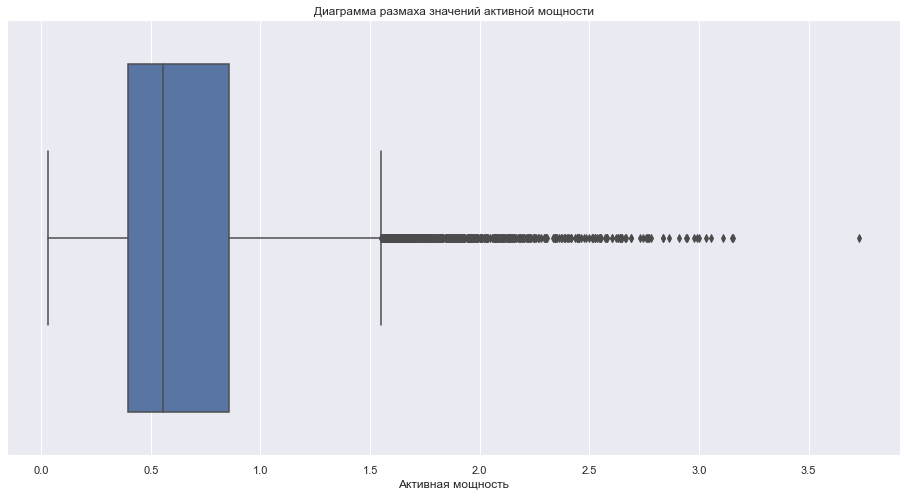

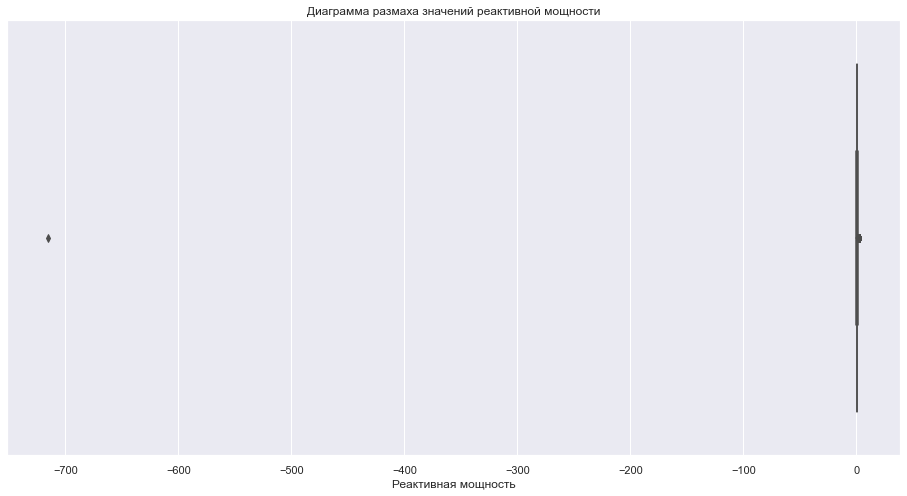

In [8]:
# Поищем выбросы в столбцах с мощностями.
display(
    data_arc_upd[['Активная мощность','Реактивная мощность']].describe()
)
sns.set(rc = {'figure.figsize':(16,8)})
sns.set_theme(style='darkgrid')
ax = sns.boxplot(x=data_arc_upd['Активная мощность'])
plt.title('Диаграмма размаха значений активной мощности')
plt.show()
ax = sns.boxplot(x=data_arc_upd['Реактивная мощность'])
plt.title('Диаграмма размаха значений реактивной мощности')
plt.show()

Теоретически реактивная мощность может быть отрицательной, но, полагаю, это не наш случай. Избавимся от выбросов (тем более их мало).

In [9]:
# Обработаем однозначные выбросы. Сначала посмотрим на строки.
# Определим индексы нужных строк.
display(data_arc_upd['Активная мощность'].sort_values())
display(data_arc_upd['Реактивная мощность'].sort_values())
# Наши индексы — 7799 и 9780
display(data_arc_upd.loc[[ 7799, 9780]])
# Посмотрим, какие обычно значения реактивной мощности
# встречаются, когда активная мощность равна приблизительно 0.495.
replacement_number_1_react = data_arc_upd.loc[
    (data_arc_upd['Активная мощность'] >= 0.49) & 
    (data_arc_upd['Активная мощность'] <= 0.495)]['Реактивная мощность'].mean()
print('Допустимое значение для замены выброса в столбце реактивной мощности', 
      replacement_number_1_react)
# Посмотрим, какие обычно значения активной мощности
# встречаются, когда реактивная мощность равна приблизительно 2.676.
display(data_arc_upd.loc[[13760, 12424, 9361, 9226, 7799]])
# Мы вполне можем заменить на любое близкое число. Например, 3.17.
replacement_number_2_act = 3.17
print('Допустимое значение для замены выброса в столбце активной мощности', 
      replacement_number_2_act)
# Произведем замены.
data_arc_upd.loc[7799, 'Активная мощность'] = replacement_number_2_act
data_arc_upd.loc[9780, 'Реактивная мощность'] = replacement_number_1_react

7372     0.030002
5596     0.030188
5320     0.030190
2419     0.030563
4914     0.031630
           ...   
14200    3.052813
9870     3.107820
12424    3.150762
9226     3.156276
7799     3.731596
Name: Активная мощность, Length: 14876, dtype: float64

9780    -715.504924
5596       0.020806
2419       0.021154
4914       0.022485
4633       0.022983
            ...    
13760      2.335088
12424      2.397032
9361       2.459959
9226       2.504206
7799       2.676388
Name: Реактивная мощность, Length: 14876, dtype: float64

,key,Активная мощность,Реактивная мощность
7799,1689,3.731596,2.676388
9780,2116,0.495782,-715.504924


Допустимое значение для замены выброса в столбце реактивной мощности 0.37064786440206177


,key,Активная мощность,Реактивная мощность
13760,2985,2.779279,2.335088
12424,2701,3.150762,2.397032
9361,2029,2.019395,2.459959
9226,2001,3.156276,2.504206
7799,1689,3.731596,2.676388


Допустимое значение для замены выброса в столбце активной мощности 3.17


,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000
mean,0.670404,0.500715
std,0.407902,0.310872
min,0.030002,0.020806
25%,0.395297,0.291008
50%,0.555517,0.415962
75%,0.857034,0.637371
max,3.170000,2.676388


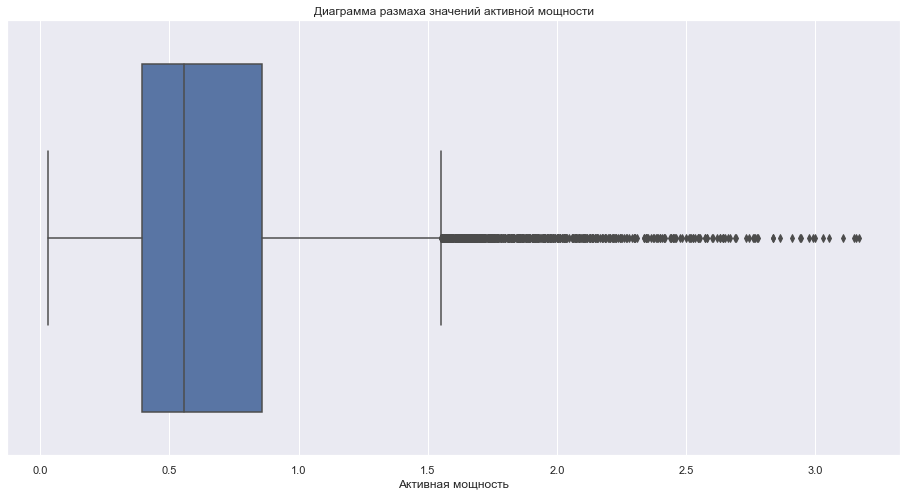

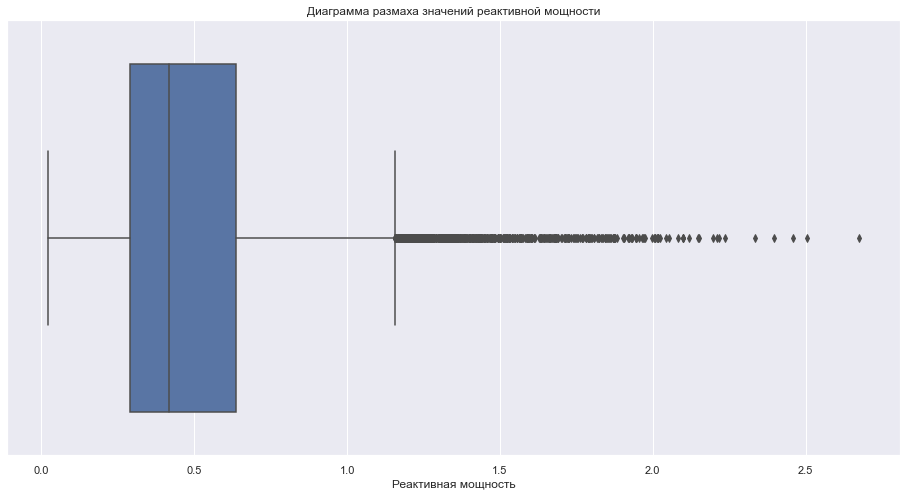

In [10]:
# Посмотрим, что стало с выбросами.
display(
    data_arc_upd[['Активная мощность','Реактивная мощность']].describe()
)
ax = sns.boxplot(x=data_arc_upd['Активная мощность'])
plt.title('Диаграмма размаха значений активной мощности')
plt.show()
ax = sns.boxplot(x=data_arc_upd['Реактивная мощность'])
plt.title('Диаграмма размаха значений реактивной мощности')
plt.show()

In [11]:
# Сгруппируем по партиям.
data_arc_grouped = data_arc_upd.pivot_table(
    index='key', 
    values=['Активная мощность', 'Реактивная мощность'], 
    aggfunc='sum'
)
display(data_arc_grouped)

,Активная мощность,Реактивная мощность
key,,
1,4.878147,3.183241
2,3.052598,1.998112
3,2.525882,1.599076
4,3.209250,2.060298
5,3.347173,2.252643
...,...,...
3237,3.932467,2.828459
3238,2.106529,1.681182
3239,4.666754,3.111617


**Таблица data_bulk**

In [12]:
# Заменим NaN-значения на 0.
data_bulk_upd = data_bulk.copy()
data_bulk_upd = data_bulk_upd.fillna(0)
display(data_bulk_upd)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,0.0,0.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,252.0,0.0,130.0,206.0
3125,3238,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,254.0,0.0,108.0,106.0
3126,3239,0.0,0.0,0.0,0.0,0.0,114.0,0.0,0.0,0.0,0.0,0.0,158.0,0.0,270.0,88.0
3127,3240,0.0,0.0,0.0,0.0,0.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,54.0


In [13]:
# Проверим на полные дубликаты.
print('Количество полных дубликатов', data_bulk.duplicated().sum())

Количество полных дубликатов 0


In [14]:
# Изучим данные не предмет очевидных аномалий.
display(data_bulk_upd.drop(['key'], axis=1).describe())

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Странных, невероятно больших или отрицательных значений объемов добавляемых примесей не найдено. При этом рекомендуется проконсультироваться с заказчиком, выяснив интервал допустимых значений объема добавляемых веществ.

In [15]:
# Посмотрим на уникальные значения в столбце key. 
# Сколько всего партий? Есть ли пропущенные?
unique_keys = data_bulk_upd['key'].value_counts().sort_index()
display(unique_keys)
print('Количество партий:', len(unique_keys))

1       1
2       1
3       1
4       1
5       1
       ..
3237    1
3238    1
3239    1
3240    1
3241    1
Name: key, Length: 3129, dtype: int64

Количество партий: 3129


В этой таблице тоже строк меньше, чем 3241. Мы должны быть внимательными при объединении таблиц.

**Таблица data_bulk_time** 

In [16]:
# Изменим формат дат и времени на DateTime.
data_bulk_time_upd = data_bulk_time.copy()
data_bulk_time_upd.loc[
    :,data_bulk_time_upd.columns != 'key'] = data_bulk_time_upd.loc[
    :, data_bulk_time_upd.columns != 'key'].apply(pd.to_datetime)
display(data_bulk_time_upd)
data_bulk_time_upd.info()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 22:46:52,NaT,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-08-31 23:33:09,NaT,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:39:41,NaT,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-01 02:41:27,2019-09-01 02:41:27


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Таблица data_gas** 

In [17]:
# Проверим на полные дубликаты.
print('Количество полных дубликатов', data_gas.duplicated().sum())

Количество полных дубликатов 0


count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

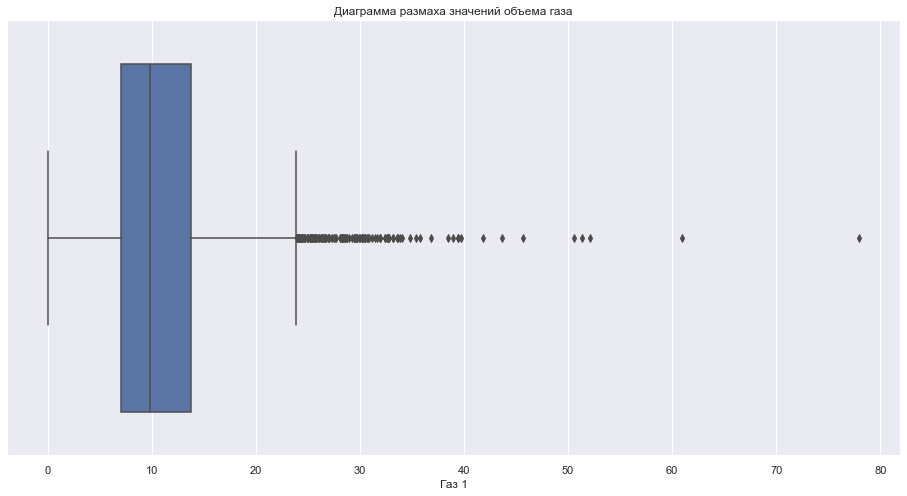

In [18]:
# Построим диаграмму размаха.
display(data_gas['Газ 1'].describe())
ax = sns.boxplot(x=data_gas['Газ 1'])
plt.title('Диаграмма размаха значений объема газа')
plt.show()

In [19]:
# Определим ключ потенциального выброса.
display(data_gas.sort_values(by='Газ 1').tail(10))
# Посмотрим на количество итераций.
display(data_arc_upd.loc[data_arc_upd['key'] == 322])
# Их целых 13.
# Сгруппируем таблицу data_arc_upd и посчитаем
# сколько итераций у каждой партии.
data_arc_grouped_2 = data_arc_upd.pivot_table(
    index='key', 
    values=['Активная мощность'], 
    aggfunc='count'
)
display(data_arc_grouped_2['Активная мощность'].sort_values())

,key,Газ 1
610,613,39.425706
525,528,39.728826
660,663,41.854643
1461,1464,43.655411
2105,2108,45.638999
116,117,50.581035
2567,2570,51.380229
2107,2110,52.142373
277,280,60.935689
319,322,77.995040


,key,Активная мощность,Реактивная мощность
1487,322,0.518544,0.382905
1488,322,0.801966,0.582975
1489,322,1.019583,0.815634
1490,322,0.294657,0.212946
1491,322,0.451133,0.363475
1492,322,1.247301,0.979751
1493,322,0.405259,0.317796
1494,322,0.707713,0.559410
1495,322,0.407723,0.321421
1496,322,0.309299,0.375072


key
943      1
2582     1
246      1
343      1
1914     1
        ..
322     13
2567    14
1689    15
1513    15
2108    16
Name: Активная мощность, Length: 3214, dtype: int64

Мы видим, что скорее всего чем больше итераций, тем больше расходовалось инертного газа. Не будем считать 77.995040 и близкие к нему значения выбросом.

**Таблица data_temp** 

In [20]:
# Изменим формат столбца Время замера на DateTime.
data_temp_upd = data_temp.copy()
data_temp_upd['Время замера'] = pd.to_datetime(data_temp_upd['Время замера'])
data_temp_upd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


В таблице **data_temp** много пропусков в столбце *Температура*. Корректно заменить эти пропуски невозможно. Нам придется избавиться от строк с пропущенными значениями, так как они повлияют на качество модели.

In [21]:
# Удаляем пропуски.
data_temp_upd = data_temp_upd.dropna()
data_temp_upd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13006 entries, 0 to 15902
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13006 non-null  int64         
 1   Время замера  13006 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 406.4 KB


In [22]:
# Проверим на полные дубликаты.
print('Количество полных дубликатов', data_temp_upd.duplicated().sum())

Количество полных дубликатов 0


count    13006.000000
mean      1591.840920
std         21.375851
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

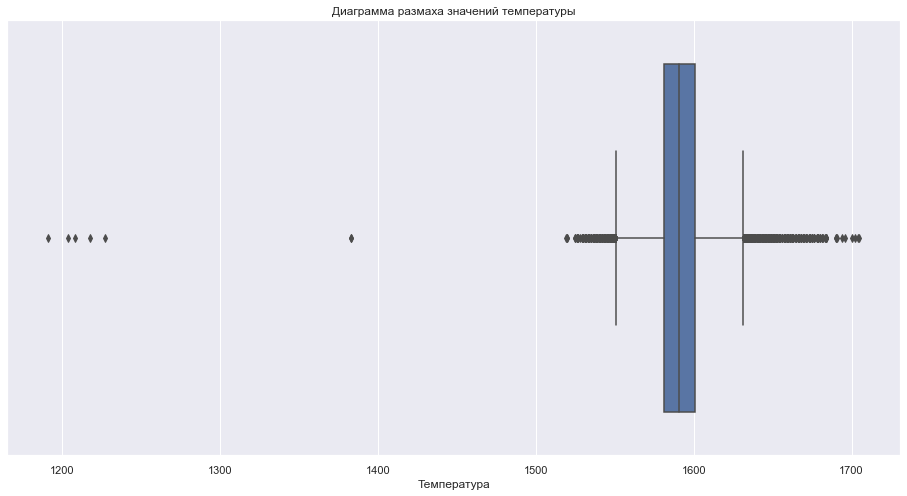

In [23]:
# Поищем выбросы.
display(data_temp_upd['Температура'].describe())
ax = sns.boxplot(x=data_temp_upd['Температура'])
plt.title('Диаграмма размаха значений температуры')
plt.show()

По условию нашей задачи, сталь заливают в ковш в уже расплавленном состоянии. Учитывая то, что температура плавления стали может быть в диапазоне от 1300 &#176;C до +/- 1500 &#176;C, значения менее 1300 &#176;C однозначно являются выбросами. Удалим их. Единственное значение больше 1300 &#176;C, но меньше 1400 &#176;C мы тоже уберем для повышения качества будущей модели.

count    12999.000000
mean      1592.020078
std         19.853665
min       1519.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Температура, dtype: float64

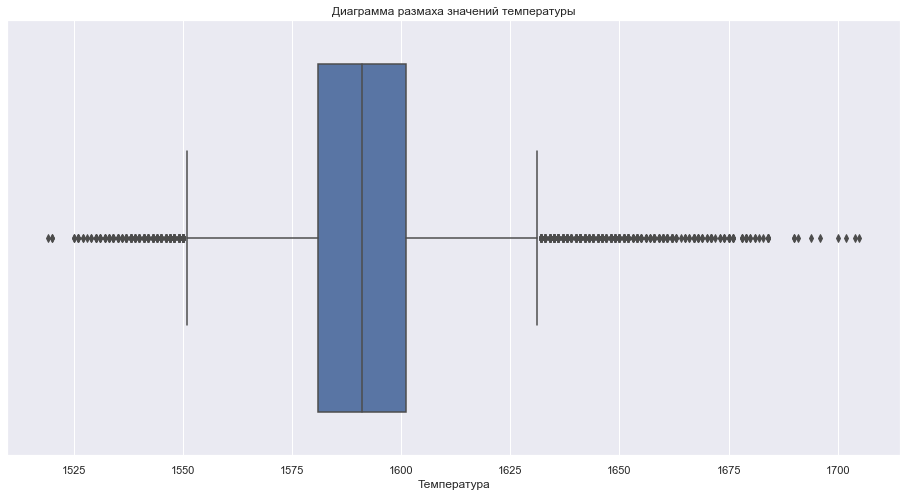

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12999 entries, 0 to 12998
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           12999 non-null  int64         
 1   Время замера  12999 non-null  datetime64[ns]
 2   Температура   12999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 304.8 KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
12994,3237,2019-08-31 22:44:04,1569.0
12995,3238,2019-08-31 23:30:31,1584.0
12996,3239,2019-09-01 01:31:47,1598.0
12997,3240,2019-09-01 02:39:01,1617.0


In [24]:
# Удалим выбросы для улучшения будущей модели.
data_temp_upd = data_temp_upd.loc[data_temp_upd['Температура'] > 1400].reset_index(drop=True)
display(data_temp_upd['Температура'].describe())
ax = sns.boxplot(x=data_temp_upd['Температура'])
plt.title('Диаграмма размаха значений температуры')
plt.show()
data_temp_upd.info()
display(data_temp_upd)

**Таблица data_wire**

In [25]:
# Заменим пропуски на 0.
data_wire_upd = data_wire.copy()
data_wire_upd = data_wire_upd.fillna(0)
display(data_wire_upd)
data_wire_upd.info()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3077,3238,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3078,3239,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3079,3240,34.070400,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3081 non-null   float64
 2   Wire 2  3081 non-null   float64
 3   Wire 3  3081 non-null   float64
 4   Wire 4  3081 non-null   float64
 5   Wire 5  3081 non-null   float64
 6   Wire 6  3081 non-null   float64
 7   Wire 7  3081 non-null   float64
 8   Wire 8  3081 non-null   float64
 9   Wire 9  3081 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [26]:
# Проверим на полные дубликаты.
print('Количество полных дубликатов', data_wire_upd.duplicated().sum())

Количество полных дубликатов 0


In [27]:
# Изучим данные не предмет очевидных аномалий.
display(data_wire_upd.drop(['key'], axis=1).describe())

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


Странных, невероятно больших или отрицательных значений объемов добавляемой проволоки не найдено. При этом рекомендуется проконсультироваться с заказчиком, выяснив интервал допустимых значений объема добавляемой проволки.

**Таблица data_wire_time**

In [28]:
# Изменим формат данных на DateTime.
data_wire_time_upd = data_wire_time.copy()
data_wire_time_upd.loc[
    :,data_wire_time_upd.columns != 'key'] = data_wire_time_upd.loc[
    :, data_wire_time_upd.columns != 'key'].apply(pd.to_datetime)
display(data_wire_time_upd)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


## 3. Подготовка данных. Объединение таблиц

Объединим все таблицы, содержащие дату и время. Определим партии, в которых операция замера температуры была последней.

In [29]:
# Объединим все таблицы, содержащие дату и время.
final = pd.merge(data_temp_upd, data_bulk_time_upd, how='outer', on='key')
final_2 = pd.merge(final, data_wire_time_upd, how='outer', on='key')
# Сразу удалим строку с NaT-значением в столбце "Время замера".
final_2 = final_2.drop(12999, axis=0)
final_2 = final_2.drop(['key', 'Температура'], axis=1)
display(final_2)
final_2.info()

,Время замера,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,2019-05-03 11:16:18,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2019-05-03 11:25:53,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,2019-05-03 11:29:11,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,2019-05-03 11:30:01,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,2019-05-03 11:30:39,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,...,2019-05-03 11:03:52,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12994,2019-08-31 22:44:04,NaT,NaT,2019-08-31 22:51:28,NaT,NaT,NaT,NaT,NaT,NaT,...,2019-08-31 22:46:52,2019-08-31 22:50:20,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12995,2019-08-31 23:30:31,NaT,NaT,2019-08-31 23:39:11,NaT,NaT,NaT,NaT,NaT,NaT,...,2019-08-31 23:33:09,2019-08-31 23:38:24,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12996,2019-09-01 01:31:47,NaT,NaT,NaT,NaT,NaT,2019-09-01 01:51:58,NaT,NaT,NaT,...,2019-09-01 01:33:25,2019-09-01 01:50:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
12997,2019-09-01 02:39:01,NaT,NaT,NaT,NaT,NaT,2019-09-01 03:12:40,NaT,NaT,NaT,...,2019-09-01 02:41:27,2019-09-01 03:12:02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


<class 'pandas.core.frame.DataFrame'>
Int64Index: 12999 entries, 0 to 12998
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Время замера  12999 non-null  datetime64[ns]
 1   Bulk 1        1154 non-null   datetime64[ns]
 2   Bulk 2        120 non-null    datetime64[ns]
 3   Bulk 3        5124 non-null   datetime64[ns]
 4   Bulk 4        4277 non-null   datetime64[ns]
 5   Bulk 5        354 non-null    datetime64[ns]
 6   Bulk 6        2443 non-null   datetime64[ns]
 7   Bulk 7        125 non-null    datetime64[ns]
 8   Bulk 8        4 non-null      datetime64[ns]
 9   Bulk 9        64 non-null     datetime64[ns]
 10  Bulk 10       730 non-null    datetime64[ns]
 11  Bulk 11       707 non-null    datetime64[ns]
 12  Bulk 12       9872 non-null   datetime64[ns]
 13  Bulk 13       106 non-null    datetime64[ns]
 14  Bulk 14       11235 non-null  datetime64[ns]
 15  Bulk 15       9002 non-null   dateti

In [30]:
# Все временные данные в формате DateTime. Значит их можно сравнить.
# Выявим строки, в которых время замера температуры последнее.
max_value = final_2.idxmax(axis=1)
print('Операция, которая выполнялась последней в данной итерации:')
display(max_value)
# Получим индексы тех строк, где имеем значением "Время замера"
idx = max_value.index[max_value == 'Время замера']
display(idx)

Операция, которая выполнялась последней в данной итерации:


0              Bulk 4
1        Время замера
2        Время замера
3        Время замера
4        Время замера
             ...     
12994          Bulk 3
12995          Bulk 3
12996          Bulk 6
12997          Bulk 6
12998          Wire 1
Length: 12999, dtype: object

Int64Index([    1,     2,     3,     4,     7,     8,     9,    10,    15,
               16,
            ...
            12590, 12622, 12666, 12667, 12706, 12781, 12822, 12945, 12956,
            12985],
           dtype='int64', length=7624)

In [31]:
# Вернемся к таблице data_temp_upd.
# Отобразим данные с выбранными ранее индексами.
data_temp_prefinal = data_temp_upd.loc[idx]
display(data_temp_prefinal)

,key,Время замера,Температура
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
7,2,2019-05-03 11:49:38,1589.0
...,...,...,...
12781,3022,2019-08-25 01:02:08,1583.0
12822,3063,2019-08-26 11:41:46,1563.0
12945,3186,2019-08-30 09:45:52,1591.0
12956,3197,2019-08-30 18:56:00,1580.0


In [32]:
# Теперь нам нужно убрать все строки каждой партии, 
# кроме последней итерации.
data_temp_final = (
    data_temp_prefinal.sort_values(
        'Время замера').groupby('key').tail(1).drop(
        ['Время замера'], axis=1
    )
)
display(data_temp_final)
data_temp_final.info()

,key,Температура
4,1,1613.0
10,2,1602.0
15,3,1599.0
18,4,1625.0
20,5,1602.0
...,...,...
12781,3022,1583.0
12822,3063,1563.0
12945,3186,1591.0
12956,3197,1580.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 4 to 12985
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          2482 non-null   int64  
 1   Температура  2482 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 58.2 KB


In [33]:
# Давайте сохраним первоначальные температуры.
# Этот признак будет полезен при моделировании.
data_temp_first = (
    data_temp_upd.sort_values('Время замера').groupby('key').head(1).drop(
        ['Время замера'], 
        axis=1
    )
)
display(data_temp_first)
data_temp_first.info()

,key,Температура
0,1,1571.0
5,2,1581.0
11,3,1596.0
16,4,1601.0
19,5,1576.0
...,...,...
12994,3237,1569.0
12995,3238,1584.0
12996,3239,1598.0
12997,3240,1617.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3215 entries, 0 to 12998
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          3215 non-null   int64  
 1   Температура  3215 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 75.4 KB


Теперь объединим данные в таблицу, которая послужит нам основной для моделирования.  
Нам нужно объединить следующие таблицы по ключу *key*:
* data_temp_final
* data_temp_first
* data_arc_grouped
* data_bulk_upd
* data_gas
* data_wire

In [34]:
# Объединяем таблицы.
pre_data_1 = pd.merge(data_temp_final, data_temp_first, how='left', on='key')
pre_data_2 = pd.merge(pre_data_1, data_arc_grouped, how='left', on='key')
pre_data_3 = pd.merge(pre_data_2, data_bulk_upd, how='left', on='key')
pre_data_4 = pd.merge(pre_data_3, data_gas, how='left', on='key')
pre_data_5 = pd.merge(pre_data_4, data_wire, how='left', on='key')
pre_data_5 = pre_data_5.rename(
    columns={'Температура_x': 'Конечная температура',
             'Температура_y': 'Начальная температура'}
)
display(pre_data_5)
pre_data_5.info()

,key,Конечная температура,Начальная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,...,5.413692,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,3022,1583.0,1583.0,3.110264,2.444044,0.0,0.0,0.0,0.0,0.0,...,9.552213,112.170234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2478,3063,1563.0,1563.0,4.436722,3.194935,0.0,0.0,58.0,0.0,0.0,...,8.373330,109.199997,76.153999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2479,3186,1591.0,1591.0,2.456302,1.857677,0.0,0.0,140.0,0.0,0.0,...,5.699542,130.166403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2480,3197,1580.0,1580.0,1.788605,1.335075,0.0,0.0,154.0,0.0,0.0,...,1.837179,30.008158,90.178398,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2482 entries, 0 to 2481
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   key                    2482 non-null   int64  
 1   Конечная температура   2482 non-null   float64
 2   Начальная температура  2482 non-null   float64
 3   Активная мощность      2480 non-null   float64
 4   Реактивная мощность    2480 non-null   float64
 5   Bulk 1                 2409 non-null   float64
 6   Bulk 2                 2409 non-null   float64
 7   Bulk 3                 2409 non-null   float64
 8   Bulk 4                 2409 non-null   float64
 9   Bulk 5                 2409 non-null   float64
 10  Bulk 6                 2409 non-null   float64
 11  Bulk 7                 2409 non-null   float64
 12  Bulk 8                 2409 non-null   float64
 13  Bulk 9                 2409 non-null   float64
 14  Bulk 10                2409 non-null   float64
 15  Bulk

In [35]:
# Столбец Wire 5 можно удалить.
# Также удалим строки, где активная и реактивная мощности, газ пропущены.
# Остальные пропуски заменим на 0.
pre_data_6 = pre_data_5.drop(['Wire 5'], axis=1)
pre_data_7 = pre_data_6.dropna(
    subset=['Активная мощность', 'Реактивная мощность', 'Газ 1']
)
data = pre_data_7.fillna(0).drop(['key'], axis=1).reset_index(drop=True)
data.info()
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Конечная температура   2478 non-null   float64
 1   Начальная температура  2478 non-null   float64
 2   Активная мощность      2478 non-null   float64
 3   Реактивная мощность    2478 non-null   float64
 4   Bulk 1                 2478 non-null   float64
 5   Bulk 2                 2478 non-null   float64
 6   Bulk 3                 2478 non-null   float64
 7   Bulk 4                 2478 non-null   float64
 8   Bulk 5                 2478 non-null   float64
 9   Bulk 6                 2478 non-null   float64
 10  Bulk 7                 2478 non-null   float64
 11  Bulk 8                 2478 non-null   float64
 12  Bulk 9                 2478 non-null   float64
 13  Bulk 10                2478 non-null   float64
 14  Bulk 11                2478 non-null   float64
 15  Bulk

,Конечная температура,Начальная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,1625.0,1601.0,3.209250,2.060298,0.0,0.0,0.0,81.0,0.0,0.0,...,154.0,18.841219,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2473,1583.0,1583.0,3.110264,2.444044,0.0,0.0,0.0,0.0,0.0,0.0,...,258.0,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2474,1563.0,1563.0,4.436722,3.194935,0.0,0.0,58.0,0.0,0.0,156.0,...,206.0,8.373330,109.199997,76.153999,0.0,0.0,0.0,0.0,0.0,0.0
2475,1591.0,1591.0,2.456302,1.857677,0.0,0.0,140.0,0.0,0.0,0.0,...,106.0,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2476,1580.0,1580.0,1.788605,1.335075,0.0,0.0,154.0,0.0,0.0,0.0,...,206.0,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 1.0, 'Гистограмма значений конечной температуры')

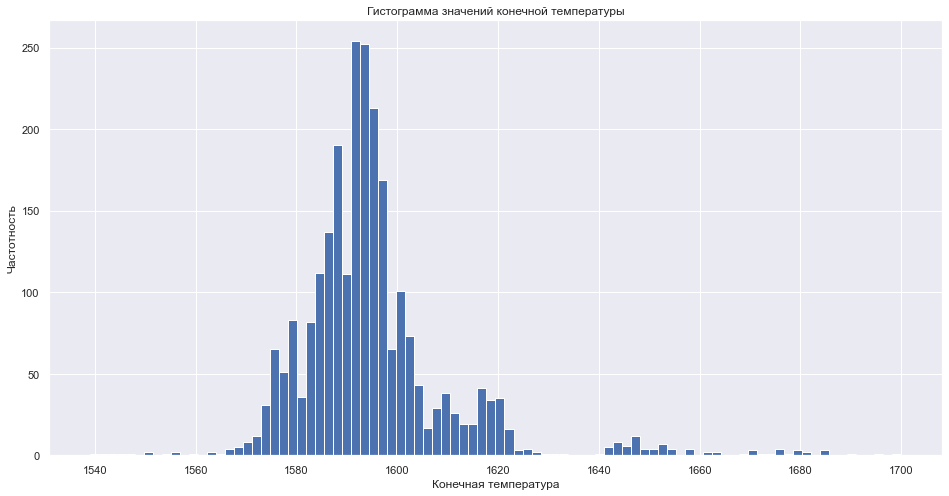

In [36]:
# Давайте посмотрим на распределение значений 
# нашего будущего целевого признака — конечной температуры
data['Конечная температура'].hist(bins=90)
plt.xlabel('Конечная температура')
plt.ylabel('Частотность')
plt.title('Гистограмма значений конечной температуры')

Обратим внимание на то, что до 1570 &#176;C и между 1625 &#176;C и 1690 &#176;C имеются выбросы. Мы понимаем, что они соответствуют в реальной жизни — такие температуры стали вполне возможны в жидком состоянии. Но для достижения необходимого уровня метрики будущей модели, мы удалим строки с этими значениями. Конечно, такие действия нужно будет согласовать с ООО "Так закаляем сталь". Если бизнес не согласует наше предложение, то необходимо рассмотреть возможность повышения уровня целевого значения метрики MAE.

In [37]:
# Избавимся от строк с выбивающимися значениями.
data = data.loc[(data['Конечная температура'] > 1570) & (data['Конечная температура'] < 1625)]

Text(0.5, 1.0, 'Гистограмма значений конечной температуры')

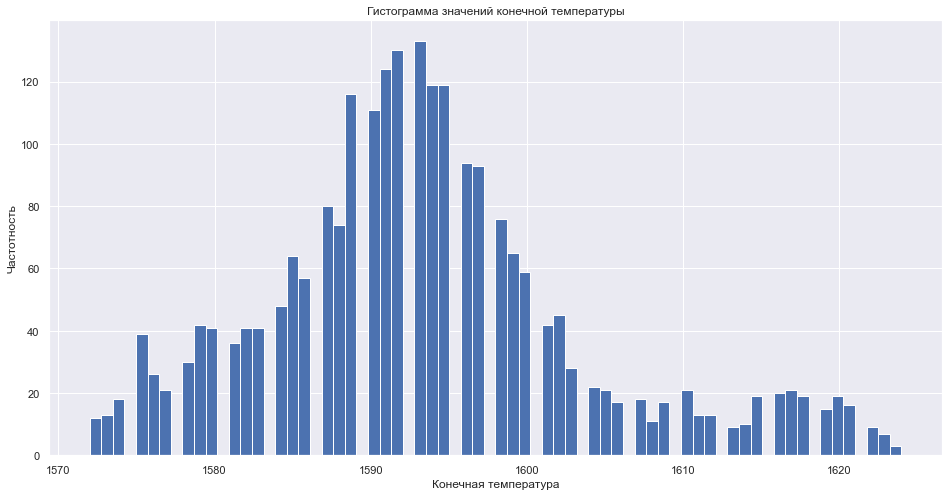

In [38]:
# Давайте посмотрим на распределение значений 
# температуры после удаления строк
data['Конечная температура'].hist(bins=70)
plt.xlabel('Конечная температура')
plt.ylabel('Частотность')
plt.title('Гистограмма значений конечной температуры')

Мы завершили исследовательский анализ данных и их подготовку к использованию в разработке модели.

## 4. Подготовка признаков

In [39]:
# Взлянем еще раз на наш датасет.
display(data)
data.info()

,Конечная температура,Начальная температура,Активная мощность,Реактивная мощность,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1613.0,1571.0,4.878147,3.183241,0.0,0.0,0.0,43.0,0.0,0.0,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,1602.0,1581.0,3.052598,1.998112,0.0,0.0,0.0,73.0,0.0,0.0,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1599.0,1596.0,2.525882,1.599076,0.0,0.0,0.0,34.0,0.0,0.0,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1602.0,1576.0,3.347173,2.252643,0.0,0.0,0.0,78.0,0.0,0.0,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
5,1596.0,1543.0,3.955108,2.689175,0.0,0.0,0.0,117.0,0.0,0.0,...,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1585.0,1585.0,2.209312,1.528631,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,7.562851,108.282722,30.461601,0.0,0.0,0.0,0.0,0.0,0.0
2473,1583.0,1583.0,3.110264,2.444044,0.0,0.0,0.0,0.0,0.0,0.0,...,258.0,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2475,1591.0,1591.0,2.456302,1.857677,0.0,0.0,140.0,0.0,0.0,0.0,...,106.0,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2476,1580.0,1580.0,1.788605,1.335075,0.0,0.0,154.0,0.0,0.0,0.0,...,206.0,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2357 entries, 0 to 2477
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Конечная температура   2357 non-null   float64
 1   Начальная температура  2357 non-null   float64
 2   Активная мощность      2357 non-null   float64
 3   Реактивная мощность    2357 non-null   float64
 4   Bulk 1                 2357 non-null   float64
 5   Bulk 2                 2357 non-null   float64
 6   Bulk 3                 2357 non-null   float64
 7   Bulk 4                 2357 non-null   float64
 8   Bulk 5                 2357 non-null   float64
 9   Bulk 6                 2357 non-null   float64
 10  Bulk 7                 2357 non-null   float64
 11  Bulk 8                 2357 non-null   float64
 12  Bulk 9                 2357 non-null   float64
 13  Bulk 10                2357 non-null   float64
 14  Bulk 11                2357 non-null   float64
 15  Bulk

In [40]:
# Определим целевой и другие признаки.
features = data.drop(['Конечная температура'], axis=1)
target = data['Конечная температура']

## 5. Проверка признаков на мультиколлинеарность

In [41]:
# Проведем анализ мультиколлинеарности.
# Создадим функцию.
def vif(features):
    vif_dataset = pd.DataFrame()
    vif_dataset['Признак'] = features.columns
    vif_dataset['VIF'] = [variance_inflation_factor(
            features.values, i) for i in range(features.shape[1])]
    
    return vif_dataset

In [42]:
# Используем функцию. Вычислим VIF.
vif(features)

C:\Users\Павел Сухих\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Признак,VIF
0,Начальная температура,13.656492
1,Активная мощность,84.680948
2,Реактивная мощность,75.821376
3,Bulk 1,1.474075
4,Bulk 2,2.364667
5,Bulk 3,1.634709
6,Bulk 4,1.947899
7,Bulk 5,1.072516
8,Bulk 6,1.507037
9,Bulk 7,1.754402


Самый высокий VIF показали признаки *Активная мощность*, *Реактивная мощность*, *Bulk 9*, *Wire 8*, *Начальная температура*.
Для начала обработаем активную и реактивную мощности. Посчитаем полную мощность, добавим её в столбец *Полная мощность*, а от столбцов *Активная мощность* и *Реактивная мощность* избавимся.

In [43]:
data['Полная мощность'] = (data['Активная мощность']**2 + data['Реактивная мощность']**2)**0.5
data = data.drop(['Активная мощность', 'Реактивная мощность'], axis=1)
display(data)

,Конечная температура,Начальная температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Полная мощность
0,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.824889
1,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.648398
2,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.989502
4,1602.0,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,4.034596
5,1596.0,1543.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,4.782734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1585.0,1585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.562851,108.282722,30.461601,0.0,0.0,0.0,0.0,0.0,0.0,2.686591
2473,1583.0,1583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.955640
2475,1591.0,1591.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0,...,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.079672
2476,1580.0,1580.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,...,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,0.0,0.0,2.231935


In [44]:
# Снова создадим группу признаков.
features = data.drop(['Конечная температура'], axis=1)
# Вычислим VIF обновленного набора признаков.
vif(features)

C:\Users\Павел Сухих\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Признак,VIF
0,Начальная температура,13.377256
1,Bulk 1,1.465256
2,Bulk 2,2.364634
3,Bulk 3,1.596298
4,Bulk 4,1.944212
5,Bulk 5,1.071933
6,Bulk 6,1.503781
7,Bulk 7,1.752761
8,Bulk 8,3.718105
9,Bulk 9,67.706270


Отлично! Нам удалось избавиться от одного признака с высоким значением VIF. Теперь нужно обработать признаки *Bulk 9*, *Wire 8*.

Конечная температура     1.000000
Начальная температура    0.313705
Bulk 1                  -0.031699
Bulk 2                   0.031862
Bulk 3                  -0.041385
Bulk 4                   0.196867
Bulk 5                   0.013570
Bulk 6                  -0.185623
Bulk 7                   0.044082
Bulk 8                  -0.028597
Bulk 9                  -0.017749
Bulk 10                  0.064785
Bulk 11                 -0.114714
Bulk 12                  0.247457
Bulk 13                 -0.001451
Bulk 14                  0.094919
Bulk 15                  0.254296
Газ 1                    0.099060
Wire 1                   0.287929
Wire 2                  -0.200577
Wire 3                  -0.032296
Wire 4                   0.029140
Wire 6                  -0.020588
Wire 7                        NaN
Wire 8                  -0.012065
Wire 9                  -0.040527
Полная мощность          0.290117
Name: Конечная температура, dtype: float64

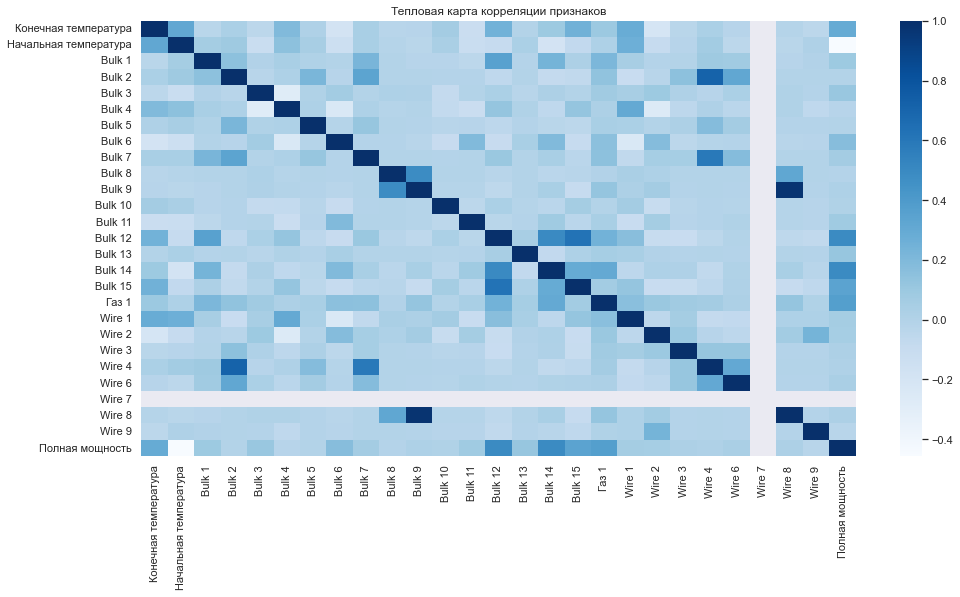

In [45]:
# Посмотрим на корреляцию признаков.
display(data.corr().iloc[:,0])
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(data.corr(), cmap='Blues')
plt.title('Тепловая карта корреляции признаков')
plt.show()

Мы видим, что признаки *Bulk 9* и *Wire 8* примерно одинаково коррелируют с целевым признаком *Конечная температура*. Но всё же *Wire 8* меньше влияет на целевой признак. Сложим его с признаком *Wire 9*. Назовём новый столбец *Wire 8_9*.

In [46]:
# Складываем столбцы.
data['Wire 8_9'] = data['Wire 8'] + data['Wire 9']
# Удаляем лишние столбцы.
data = data.drop(['Wire 8', 'Wire 9'], axis=1)
display(data)

,Конечная температура,Начальная температура,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,...,Bulk 15,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Полная мощность,Wire 8_9
0,1613.0,1571.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,154.0,29.749986,60.059998,0.000000,0.0,0.0,0.0,0.0,5.824889,0.0
1,1602.0,1581.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,...,154.0,12.555561,96.052315,0.000000,0.0,0.0,0.0,0.0,3.648398,0.0
2,1599.0,1596.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,...,153.0,28.554793,91.160157,0.000000,0.0,0.0,0.0,0.0,2.989502,0.0
4,1602.0,1576.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,...,152.0,5.413692,89.238236,9.114560,0.0,0.0,0.0,0.0,4.034596,0.0
5,1596.0,1543.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,...,154.0,11.273392,99.109917,9.114560,0.0,0.0,0.0,0.0,4.782734,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,1585.0,1585.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,7.562851,108.282722,30.461601,0.0,0.0,0.0,0.0,2.686591,0.0
2473,1583.0,1583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,258.0,9.552213,112.170234,0.000000,0.0,0.0,0.0,0.0,3.955640,0.0
2475,1591.0,1591.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0,...,106.0,5.699542,130.166403,0.000000,0.0,0.0,0.0,0.0,3.079672,0.0
2476,1580.0,1580.0,0.0,0.0,154.0,0.0,0.0,0.0,0.0,0.0,...,206.0,1.837179,30.008158,90.178398,0.0,0.0,0.0,0.0,2.231935,0.0


In [47]:
# Снова создадим группу признаков.
features = data.drop(['Конечная температура'], axis=1)
# Вычислим VIF обновленного набора признаков.
vif(features)

C:\Users\Павел Сухих\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1738: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,Признак,VIF
0,Начальная температура,13.377026
1,Bulk 1,1.464501
2,Bulk 2,2.364632
3,Bulk 3,1.596298
4,Bulk 4,1.935211
5,Bulk 5,1.071898
6,Bulk 6,1.501612
7,Bulk 7,1.752692
8,Bulk 8,1.372459
9,Bulk 9,2.550128


In [48]:
# Взглянем на размеры наших обновленных таблиц.
print('Размер датасета', data.shape)
print('Размер набора с признаками', features.shape)
print('Размер набора целевого признака', target.shape)

Размер датасета (2357, 26)
Размер набора с признаками (2357, 25)
Размер набора целевого признака (2357,)


Мы добились допустимых пределов мультиколлинеарности признаков. К сожалению, начальная температура довольно сильно коррелирует с полной мощностью, но мы оставим этот признак ввиду его важности, ввиду его физического влияния на целевой признак. Приступим к подготовке тренировочного и тестового наборов.

## 6. Разбиение датасета на тренировочный и тестовый наборы

Поделим датасет на 2 набора в соотношении 3:1.

In [49]:
# Поделим датасет на тренировочный и тестовый наборы.
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target, 
    test_size=.25,
    random_state=12345
)
# Проверим размеры.    
set_names = ['features_train', 'target_train',
             'features_test', 'target_test']
samples = [features_train, target_train,
             features_test, target_test]
for name, kit in zip(set_names, samples):
    print('Размер выборки', name, 'составляет', kit.shape)

Размер выборки features_train составляет (1767, 25)
Размер выборки target_train составляет (1767,)
Размер выборки features_test составляет (590, 25)
Размер выборки target_test составляет (590,)


Мы разбили наш датасет на тренировочный и тестовый наборы. Приступаем к созданию модели.

## 7. Создание модели. Подбор гиперпараметров с помощью кросс-валидации

Мы будем строить модель градиентного бустинга от Light GBM. Light GBM отлично справляется с задачами регрессии. Мы будем использовать тип бустинга GBDT: градиентный бустинг на решающем дереве. Стало быть мы можем не делать стандартизацию признаков тренировочного набора, так как GBDT практически не чувствителен к ней.

**Градиентный бустинг Light GBM**

In [50]:
%%time
# Создадим модель градиентного бустинга
# при помощи библиотеки Light GBM.
model_gb = lgb.LGBMRegressor(random_state=12345)
param_grid = {
    'boosting_type': ['gbdt'],
    'max_depth' : [2, 3, 4, 5, 6],
    'n_estimators' : [20, 50, 70, 100, 130, 150, 160],
    'learning_rate' : [0.001, 0.01, 0.05, 0.1],
    'num_leaves' : [10, 20, 30]
}
# Подберем гиперпараметры.
grid_cv_gb = GridSearchCV(estimator=model_gb, 
                          param_grid=param_grid, 
                          scoring='neg_mean_absolute_error',
                          cv=5,
                          n_jobs=-1)
grid_cv_gb.fit(features_train, target_train)
# Выявим лучшие параметры.
best_parameters = grid_cv_gb.best_params_
print('Лучшие значения гиперпараметров:\n', best_parameters)
# Выявим лучшее значение MAE.
best_cv_gb_score = abs(grid_cv_gb.best_score_)
print(f'Лучшая MAE модели градиентного бустинга {best_cv_gb_score:.1f}')

Лучшие значения гиперпараметров:
 {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 160, 'num_leaves': 10}
Лучшая MAE модели градиентного бустинга 5.9
Wall time: 20.9 s


## 8. Тестирование модели

Протестируем модель.

In [51]:
# Создадим модель Light GBM.
model_gb = lgb.LGBMRegressor(boosting_type='gbdt', 
                             random_state=12345,
                             max_depth=5,
                             learning_rate=0.05,
                             n_estimators=160,
                             num_leaves=10)
model_gb.fit(features_train, target_train)
# Сделаем предсказания.
predictions_gb = pd.Series(
    model_gb.predict(features_test), 
    index=target_test.index
    )
mae_gb = mean_absolute_error(target_test, predictions_gb)
print(f'MAE модели Light GBM на тестовой выборке составляет {mae_gb:.1f}')

MAE модели Light GBM на тестовой выборке составляет 5.5


## 9. Анализ важности признаков модели

In [52]:
# Создадим функцию просмотра важности признаков.
def importance(model):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features) 
    importance.sort_values(ascending=False).plot(
        kind='bar', 
        x=importance.index, 
        y=importance,
        title='Столбчатая диаграмма важности признаков')

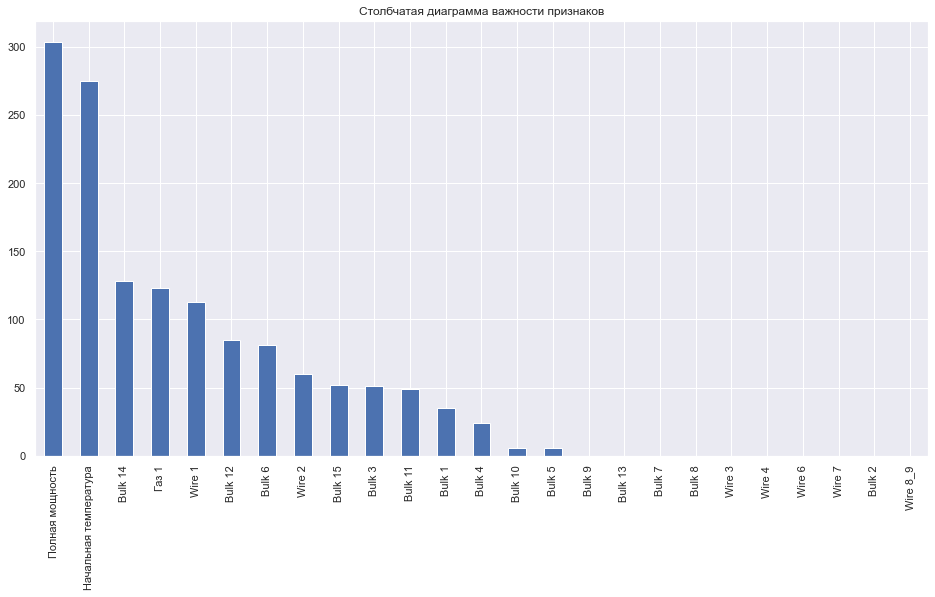

In [53]:
# Изучим важность признаков.
importance(model_gb)

In [54]:
importance = model_gb.feature_importances_
colums_features = features.columns 
importance = pd.Series(importance, index=colums_features) 
display(importance.sort_values(ascending=False))

Полная мощность          304
Начальная температура    275
Bulk 14                  128
Газ 1                    123
Wire 1                   113
Bulk 12                   85
Bulk 6                    81
Wire 2                    60
Bulk 15                   52
Bulk 3                    51
Bulk 11                   49
Bulk 1                    35
Bulk 4                    24
Bulk 10                    6
Bulk 5                     6
Bulk 9                     0
Bulk 13                    0
Bulk 7                     0
Bulk 8                     0
Wire 3                     0
Wire 4                     0
Wire 6                     0
Wire 7                     0
Bulk 2                     0
Wire 8_9                   0
dtype: int32

Мы видим, что признаки *Wire 3*, *Wire 6*, *Wire 4*, *Wire 7*, *Bulk 13*, *Bulk 2*, *Bulk 13*, *Bulk 9*, *Bulk 8*, *Bulk 7*, *Wire 8_9* вообще не имеют влияния на целевой признак. В то время как проволока *Wire 1*, затрачиваемая полная мощность, начальная температура, и добавка *Bulk 12* существенно влияют на температуру стали. Эту информацию стоит передать заказчику.

## 10. Проверка модели на вменяемость

In [55]:
# Проверим модель на вменяемость
dummy_model = DummyRegressor()
dummy_model.fit(features_train, target_train)
predictions_dummy = pd.Series(
    dummy_model.predict(features_test), 
    index=target_test.index
    )
mae_dummy = mean_absolute_error(target_test, predictions_dummy)
print(f'MAE dummy-модели равна {mae_dummy:.1f}')
if mae_dummy < mae_gb:
    print('Наша модель невменяема. Требуется доработка.')
else:
    print('Наша модель вменяема.')

MAE dummy-модели равна 7.8
Наша модель вменяема.


## 11. Вывод

Давайте еще раз пройдемся по выполненным задачам.  
Во время работы над проектом мы:
1. Загрузили данные и изучили их
2. Провели исследовательский анализ данных, во время которого подробно рассмотрели каждый датасет, обработали пропуски, выбросы (требует согласования с заказчиком), аномалии. Провели группировку данных. Определили целевой признак.
3. Подготовили данные для моделирования. Объединили таблицы в один базовый датасет.
4. Подготовили наборы признаков: целевой (Температура) и остальные.
5. Проверили признаки на мультиколлинеарность. Изучили корреляцию. Привели мультиколлинеарность к допустимым пределам.
6. Разбили датасет на тренировочный и тестовый наборы.
7. Создали модель градиентного бустинга Light GBM. Подобрали гиперпараметры с помощью кросс-валидации.
8. Протестировали модель. MAE нашей модели составила 5,5.
9. Провели анализ важности признаков у модели. Подготовили перечень признаков, не влияющих на целевой признак. Определили важнейшие факторы влияния на целевой признак.
10. Проверили модель на вменяемость. Модель вменяема.

Во время работы возникли следующие трудности:  
* Пришлось принять непростое решение по удалению из датасета выбросов признака *Температура*. Оно сделало модель более искуственной, чем она могла бы быть. Были, конечно, очевидные выбросы — значения меньше температуры плавления. Остальные выбросы были вполне реальными и физически обусловленными. Тем не менее я принял решение их удалить, чтобы добиться максимально высокого значения метрики MAE.  
* Изначально я использовал библиотеку CatBoost. С её помощью на тренировочной выборке удалось достигать значения MAE равного 5,7. К сожалению, это достигалось за счет большого количества итераций (порядка 1000), и, как следствие, модель переобучалась. Значение MAE на тестовой выборке было катастрофическим — порядка 30. Чтобы избавиться от переобучения, я перенастроил гиперпараметры. Уменьшил количество итераций до 40-50, уменьшил максимальную глубину дерева, изменил скорость обучения. MAE тестовой выборки уменьшился, но недостаточно. Затем я решил использовать Light GBM — библиотеку, которая славится своими успехами в решении задачи регрессии. Она показала лучшие результаты.

Ключевыми шагами в решении задачи стали:
* Обработка данных. Удаление выбросов и аномалий, обработка пропусков.
* Определение целевого признака. Мы точно определили, какая именно температура должна стать целевым признаком. Именно та, которая была измерена в последнюю очередь (в качестве последней операции).
* Корректное объединение таблиц, группировка значений по партиям.
* Грамотный инжинирнг признаков.
* Проверка признаков на мультиколлинеарность.
* Корректный подбор гиперпараметров модели.

In [56]:
model_gb.get_params

<bound method LGBMModel.get_params of LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=160, num_leaves=10,
              random_state=12345)>

Наша итоговая модель: регрессор от Light GBM. LGBMRegressor(max_depth=5, n_estimators=160, num_leaves=10, random_state=12345, learning_rate=0.05)